In [1]:
import time
import timeit

import pandas as pd
import numpy as np
import numba as nb
from matplotlib import pyplot as plt

In [2]:
np.random.seed(23)

In [3]:
# Загрузим данные и переименуем столбцы.

interactions = pd.read_csv('interactions.csv')

interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'datetime',
        'total_dur': 'weight'
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [4]:
# Загрузим данные.

items = pd.read_csv('items.csv')
users = pd.read_csv('users.csv')

In [5]:
# Функция для генерации выборки

def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions['user_id'].unique(), users_count, replace=False)
    df = interactions[interactions['user_id'].isin(users)].reset_index(drop=True)
    del df['datetime'], df['weight'], df['watched_pct']
    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    
    return df, users, recs

In [6]:
# Функции реализующие 3 варианта mrr.

def naive_mrr(target, users, recs):
    mrr = []
    r = 0
    for i, user in enumerate(users):
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                r = 1/(j+1)
                break
            else:
                r = 0
        mrr.append(r)
    return sum(mrr)/len(users)


def pandas_mrr(df, users, recs):
    k = recs.shape[1]
    df_recs = pd.DataFrame({'user_id': np.repeat(users, k), 'item_id': recs.ravel()})
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df['target'] = 1
    df_recs = df_recs.merge(df, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
    df.drop(['target'], axis=1, inplace=True)
    df_recs['reciprocal_rank'] = 0
    df_recs.loc[~df_recs['target'].isna(), 'reciprocal_rank'] = 1/(df_recs.loc[~df_recs['target'].isna(), 'rank'])
    mrr = df_recs.groupby('user_id')['reciprocal_rank'].max().sum()/len(users)
    return mrr


# Функция для прогрева njit.
@nb.njit()
def summa(a, b):
    return a + b


@nb.njit()
def numba_mrr(target, users, recs):
    result_mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        mrr = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr = 1 / (j + 1)
                break
        result_mrr[i] = mrr
    return result_mrr.mean()

In [7]:
# Сначала проверим, что все три функции считают метрику одиеаково.

top_k = 10
df, users, recs = generate_subsample(5000, top_k)
target = df.values

In [8]:
# Для прогрева njit.
a = 1
b = 2
summa(a, b)

3

In [9]:
# Выведем метрику, подсчитанную тремя способами. 

print(naive_mrr(target, users, recs))
print(pandas_mrr(df, users, recs))
print(numba_mrr(target, users, recs))

0.07879158730158735
0.0787915873015873
0.07879158730158735


In [10]:
# Замерим время выполнения функций.

%timeit naive_mrr(target, users, recs)

1.13 s ± 93.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit pandas_mrr(df, users, recs)

40.9 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit numba_mrr(target, users, recs)

344 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# Посчитаем время с разным количеством пользователей и top к.

users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]

# Сначала посчитаем время для top_k = 10
time_k10_naive = []
time_k10_pandas = []
time_k10_numba = []
for j in range(len(users_count)):
    df, users, recs = generate_subsample(users_count[j], top_k[0])
    target = df.values
    time = timeit.timeit('naive_mrr(target, users, recs)', "from __main__ import naive_mrr, target, users, recs", number = 1)
    time_k10_naive.append(time)
    print("Время выполнения метода naive  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[0])
    time = timeit.timeit('pandas_mrr(df, users, recs)', "from __main__ import pandas_mrr, df, users, recs", number = 1)
    time_k10_pandas.append(time)
    print("Время выполнения метода pandas  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[0])
    time = timeit.timeit('numba_mrr(target, users, recs)', "from __main__ import numba_mrr, target, users, recs", number = 1)
    time_k10_numba.append(time)
    print("Время выполнения метода numba  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[0])

Время выполнения метода naive   0.011327300000001372  Количество пользователей  100  Топ к равно  10
Время выполнения метода pandas   0.009920900000000898  Количество пользователей  100  Топ к равно  10
Время выполнения метода numba   0.00017210000000034142  Количество пользователей  100  Топ к равно  10
Время выполнения метода naive   0.12173230000000146  Количество пользователей  1000  Топ к равно  10
Время выполнения метода pandas   0.01415399999999778  Количество пользователей  1000  Топ к равно  10
Время выполнения метода numba   0.01335770000000025  Количество пользователей  1000  Топ к равно  10
Время выполнения метода naive   2.7159901000000026  Количество пользователей  10000  Топ к равно  10
Время выполнения метода pandas   0.07443899999999815  Количество пользователей  10000  Топ к равно  10
Время выполнения метода numba   1.3555579000000009  Количество пользователей  10000  Топ к равно  10
Время выполнения метода naive   180.7352914  Количество пользователей  100000  Топ к 

In [15]:
# Посчитаем для top_k = 50

time_k50_naive = []
time_k50_pandas = []
time_k50_numba = []
for j in range(len(users_count)):
    df, users, recs = generate_subsample(users_count[j], top_k[1])
    target = df.values
    time = timeit.timeit('naive_mrr(target, users, recs)', "from __main__ import naive_mrr, target, users, recs", number = 1)
    time_k50_naive.append(time)
    print("Время выполнения метода naive  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[1])
    time = timeit.timeit('pandas_mrr(df, users, recs)', "from __main__ import pandas_mrr, df, users, recs", number = 1)
    time_k50_pandas.append(time)
    print("Время выполнения метода pandas  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[1])
    time = timeit.timeit('numba_mrr(target, users, recs)', "from __main__ import numba_mrr, target, users, recs", number = 1)
    time_k50_numba.append(time)
    print("Время выполнения метода numba  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[1])

Время выполнения метода naive   0.028786400000001322  Количество пользователей  100  Топ к равно  50
Время выполнения метода pandas   0.011979300000007242  Количество пользователей  100  Топ к равно  50
Время выполнения метода numba   0.00023949999996375482  Количество пользователей  100  Топ к равно  50
Время выполнения метода naive   0.3372767999999837  Количество пользователей  1000  Топ к равно  50
Время выполнения метода pandas   0.028153299999985393  Количество пользователей  1000  Топ к равно  50
Время выполнения метода numba   0.013239700000042376  Количество пользователей  1000  Топ к равно  50
Время выполнения метода naive   4.944973199999993  Количество пользователей  10000  Топ к равно  50
Время выполнения метода pandas   0.30339200000003075  Количество пользователей  10000  Топ к равно  50
Время выполнения метода numba   1.368221099999971  Количество пользователей  10000  Топ к равно  50
Время выполнения метода naive   206.18636330000004  Количество пользователей  100000  

In [17]:
# Посчитаем для top_k = 100

time_k100_naive = []
time_k100_pandas = []
time_k100_numba = []
for j in range(len(users_count)):
    df, users, recs = generate_subsample(users_count[j], top_k[2])
    target = df.values
    time = timeit.timeit('naive_mrr(target, users, recs)', "from __main__ import naive_mrr, target, users, recs", number = 1)
    time_k100_naive.append(time)
    print("Время выполнения метода naive  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[2])
    time = timeit.timeit('pandas_mrr(df, users, recs)', "from __main__ import pandas_mrr, df, users, recs", number = 1)
    time_k100_pandas.append(time)
    print("Время выполнения метода pandas  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[2])
    time = timeit.timeit('numba_mrr(target, users, recs)', "from __main__ import numba_mrr, target, users, recs", number = 1)
    time_k100_numba.append(time)
    print("Время выполнения метода numba  ", time, " Количество пользователей ", users_count[j], " Топ к равно ", top_k[2])

Время выполнения метода naive   0.03799149999997553  Количество пользователей  100  Топ к равно  100
Время выполнения метода pandas   0.012434100000064063  Количество пользователей  100  Топ к равно  100
Время выполнения метода numba   0.0002091000000064014  Количество пользователей  100  Топ к равно  100
Время выполнения метода naive   0.5230069000000412  Количество пользователей  1000  Топ к равно  100
Время выполнения метода pandas   0.052748499999893284  Количество пользователей  1000  Топ к равно  100
Время выполнения метода numba   0.01405899999997473  Количество пользователей  1000  Топ к равно  100
Время выполнения метода naive   7.006679200000008  Количество пользователей  10000  Топ к равно  100
Время выполнения метода pandas   0.5760629999999765  Количество пользователей  10000  Топ к равно  100
Время выполнения метода numba   1.446743500000025  Количество пользователей  10000  Топ к равно  100
Время выполнения метода naive   221.19855439999992  Количество пользователей  100

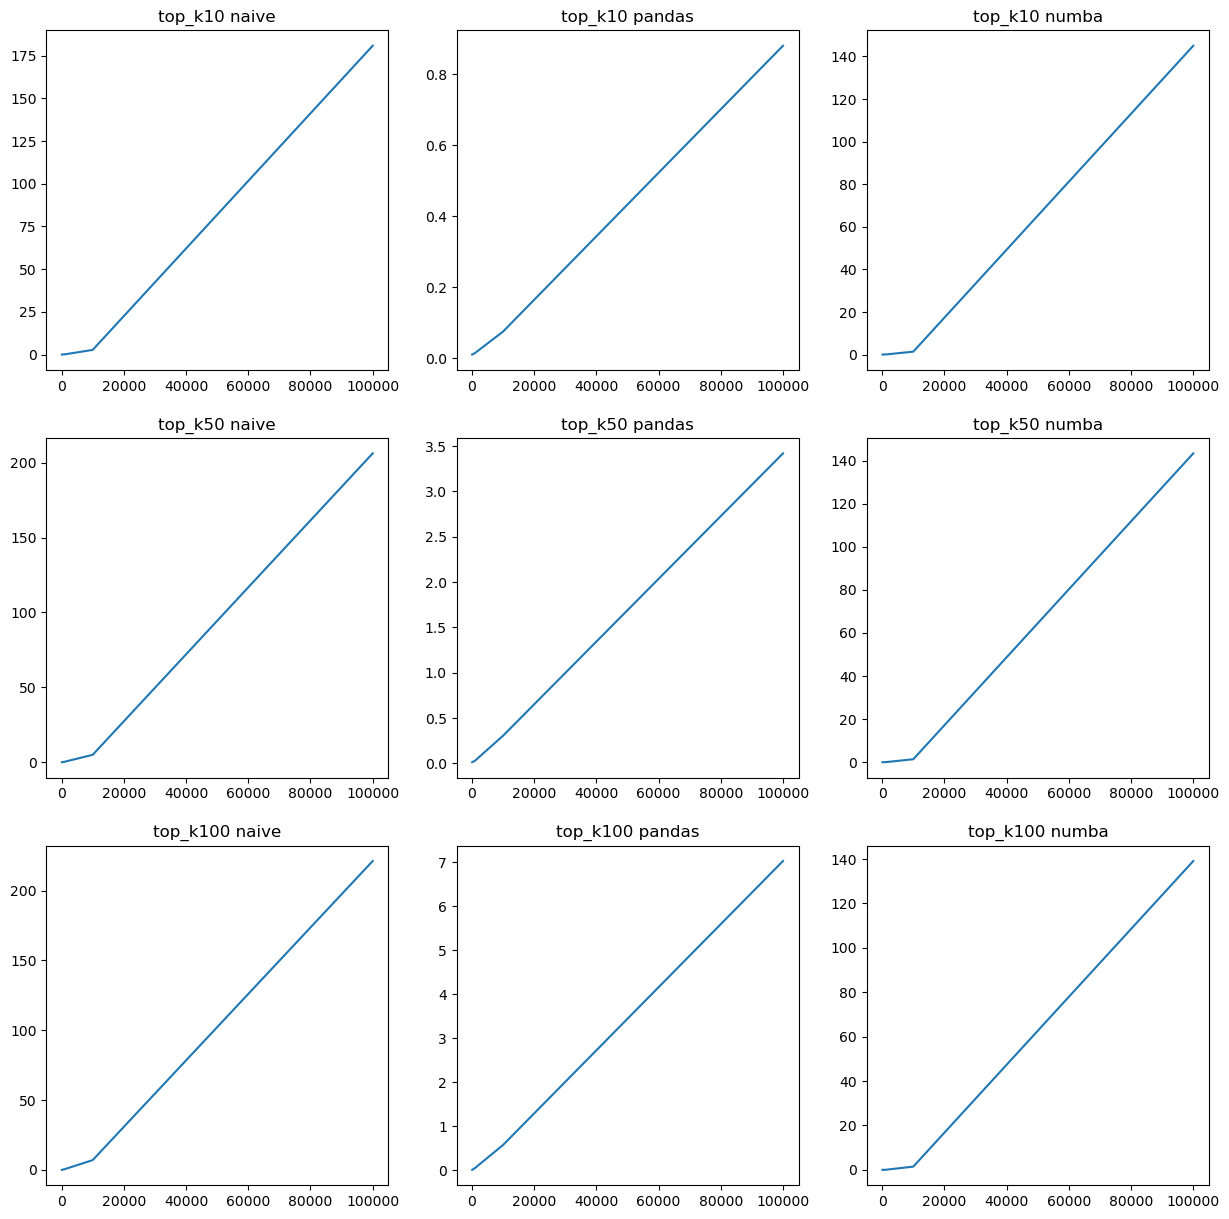

In [32]:
# Выведем графики времени и количества пользователей для разных top k.

fig, ax = plt.subplots(nrows= 3 , ncols= 3, figsize=(15,15) )
ax[0][0].plot(users_count, time_k10_naive)
ax[0][0].set_title("top_k10 naive")
ax[0][1].plot(users_count, time_k10_pandas)
ax[0][1].set_title("top_k10 pandas")
ax[0][2].plot(users_count, time_k10_numba)
ax[0][2].set_title("top_k10 numba")
ax[1][0].plot(users_count, time_k50_naive)
ax[1][0].set_title("top_k50 naive")
ax[1][1].plot(users_count, time_k50_pandas)
ax[1][1].set_title("top_k50 pandas")
ax[1][2].plot(users_count, time_k50_numba)
ax[1][2].set_title("top_k50 numba")
ax[2][0].plot(users_count, time_k100_naive)
ax[2][0].set_title("top_k100 naive")
ax[2][1].plot(users_count, time_k100_pandas)
ax[2][1].set_title("top_k100 pandas")
ax[2][2].plot(users_count, time_k100_numba)
ax[2][2].set_title("top_k100 numba")
#ax.legend()
plt.show()

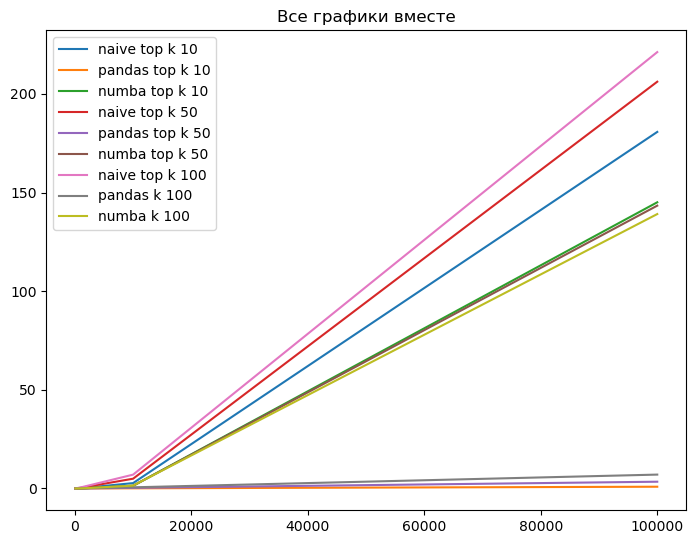

In [31]:
# Выведем общий график для трех функций.

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Все графики вместе")
ax.plot(users_count, time_k10_naive, label="naive top k 10")
ax.plot(users_count, time_k10_pandas, label="pandas top k 10")
ax.plot(users_count, time_k10_numba, label="numba top k 10")

ax.plot(users_count, time_k50_naive, label="naive top k 50")
ax.plot(users_count, time_k50_pandas, label="pandas top k 50")
ax.plot(users_count, time_k50_numba, label="numba top k 50")

ax.plot(users_count, time_k100_naive, label="naive top k 100")
ax.plot(users_count, time_k100_pandas, label="pandas k 100")
ax.plot(users_count, time_k100_numba, label="numba k 100")

ax.legend()
plt.show()

In [ ]:
# Видим, что примерно до 10 000 пользователей разброс не сильный, а дальше графики расходятся. 